# Project Outline

This project looks at the stock price of Roku. By doing a time series analysis and also a sentiment analysis on social media for the stock price of Roku we will try and predict future prices.

Project flow:
 * Gather stock price (Gathering_Data notebook)
 * Gather posts from twitter and reddit (Gathering_Data notebook)
 * Clean up and do EDA (Gathering_Data notebook)
 * Do a sentiment analysis for each day (This notebook)
 * Do a time series analysis on both stock price and sentiment individually (This notebook)
 * Combine the sentiment and stock price to try and predict future prices (This notebook)

Things to do:
 - Work with updated data
 - save and deploy model
 - Make online dashboard

# Importing packages and loading data

In [2]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import twint
import spacy
import keras
from spacytextblob.spacytextblob import SpacyTextBlob
import datetime as dt
import time
import re
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import pmdarima as pm
from statsmodels.graphics.gofplots import qqplot
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import concatenate
import pickle
from wordcloud import WordCloud, STOPWORDS



pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

Using TensorFlow backend.
/Users/stevenkyle/opt/anaconda3/envs/Capstone-new2/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Loading data
T_df = pd.read_csv('TwitterData.csv', header=None)
T_df.columns = ['id', 'date', 'timezone', 'tweet', 'language', 'cashtags', 
                'username', 'day', 'hour', 'nlikes', 'nreplies', 'nretweets', 'search']
R_df = pd.read_csv('redditdata.csv')
S_df = pd.read_csv('StockData.csv')

# Functions

In [4]:
# This function will remove emojis from the text

def RemoveEmojis(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [5]:
# This function is to run text through spacy/textblob pipeline
def Sentiment(text):
    
    #Initializing Sentiment analyzer
    SIA = SentimentIntensityAnalyzer()
    
    # Words to add to the sentiment lexicon
    new_words = {
        'bullish': 3.4,
        'bull':3.4,
        'long':3.4,
        'longs':3.4,
        'Holding':3.4,
        'holding':3.4,
        'Hodl':3.4,
        'hodl':3.4,
        'Call':3.4,
        'Calls':3.4,
        'call':3.4,
        'calls':3.4,
        'Put':-3.9,
        'Puts':-3.9,
        'put':-3.9,
        'puts':-3.9,
        'bear':-3.9,
        'bearish':-3.9,
        'short': -3.9,
        'shorts':-3.9
        }

    # Updating lexicon
    SIA.lexicon.update(new_words)
    
    # Running
    output = SIA.polarity_scores(text)
    
    return output['compound']

In [6]:
# This function will calculate the mse

def mse_calc(data, prediction, start, column):
    y_hat = prediction.predicted_mean
    real_values = data[start:][column]
    mse = ((real_values-y_hat)**2).mean()
    return mse

In [7]:
# This function will plot the timeseries and the predicted values from the model

def PlotPredictions(obs_data, pred_data, pred_data_conf, figsize=(15,8), beg='2013', title='title'):
    
    plt.figure(figsize=figsize)
    
    # Plot observed values
    ax = obs_data[beg:].plot(label='Observed')

    # Plot predicted values
    pred_data.predicted_mean.plot(ax=ax)

    # Plot the range for confidence intervals
    ax.fill_between(pred_data_conf.index,
                pred_data_conf.iloc[:, 0],
                pred_data_conf.iloc[:, 1], color='g', alpha=0.1)

    # Set axes labels
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.legend()
    plt.show()

In [8]:
# This function is used to try different sets of parameters for SARIMAX
# It will return a dataframe with the parameters and the aic values

def Grid_Auto_bot(data, order_list):

    # Initializing an empty list for storing results
    results=[]

    # Going through and creating a model using all combinations of order
    # Also outputing order/aic score to a list
    for comb in order_list:
        try:
            mod = ARIMA(data, order = comb, freq='B')
            output = mod.fit()
            results.append([comb,ARIMAResults.aic(output)])
            print('ARIMA {} : AIC Calculated ={}'.format(comb, ARIMAResults.aic(output)))
             
        except:
            continue
                
    # Creating a dataframe for the results
    ans_df = pd.DataFrame(results, columns=['pdq','aic'])
    
    # Making aic column into numeric
    ans_df['aic'] = pd.to_numeric(ans_df['aic'])
    
    return ans_df

In [9]:
# This function will do an arima model using the order that is put in and will display the
# residual diagnostics and predictions

def ArimaModelDiagnostics(data,order,pred_start):
    # Making the train ARIMA model
    Train_model = ARIMA(data,
                        order=order,
                        freq='B')
    train_output = Train_model.fit()
    
    # Shows the train model summary
    print('Train_model summary')
    display(train_output.summary());

    # Plotting the residuals for the model
    residuals = pd.DataFrame(train_output.resid)

    fig1, axes = plt.subplots(figsize=(14,8),nrows=2, ncols=2)
    fig1.tight_layout(pad=1, w_pad=2, h_pad=5)

    residuals.plot(ax=axes[0,0])
    residuals.plot(kind='kde',ax=axes[0,1])
    plot_acf(residuals, ax=axes[1,1]);
    qqplot(train_output.resid,line='s',ax=axes[1,0]);

    axes[0,0].set_title('Residuals');
    axes[0,1].set_title('KDE');
    axes[1,0].set_title('QQ-Plot');

    # Plotting the Predictions of the model
    fig2, ax = plt.subplots(figsize=(12,8))
    fig2 = train_output.plot_predict(start=pred_start,ax=ax);
    ax.set_title('Predictions of the model');
    ax.set_ylabel('Closing Price');
    ax.set_xlabel('Date');

In [10]:
def ArimaSubsetTest(data, order, test_size, plot_start, logged=False):
    # Split train data to a subset test data to see how well it predicts
    # Subset test data will be 20 days
    split = len(data) - test_size
    Train_train = data[:split]
    Train_test = data[split:]

    # Testing subset test
    model = ARIMA(Train_train, order=order)  
    fitted = model.fit()  

    # Forecast
    fc, se, conf = fitted.forecast(test_size, alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=Train_test.index)
    lower_series = pd.Series(conf[:, 0], index=Train_test.index)
    upper_series = pd.Series(conf[:, 1], index=Train_test.index)

    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(Train_train[plot_start:], label='Training')
    plt.plot(Train_test, label='Testing')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.show()

    if logged == False:
        # Get the error
        error = Train_test - fc_series
        mse = ((error)**2).mean()
        rmse = np.sqrt(mse)
        print('MSE was ', mse, 'and rmse was', rmse)

    elif logged == True:
        # Get the error
        unlog_test = np.exp(Train_test)
        unlog_fc = np.exp(fc_series)
        error = unlog_test - unlog_fc
        mse = ((error)**2).mean()
        rmse = np.sqrt(mse)
        print('MSE was ', mse, 'and rmse was', rmse)

In [11]:
# Arima final forecast for test data
def ArimaTestForecast(train, test, order, test_size, plot_start, logged=False):
    # Getting forecast for the test model
    model = ARIMA(train, order=raw_order_2)  
    fitted = model.fit()  

    # Forecast
    fc, se, conf = fitted.forecast(test_size, alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)

    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train[plot_start:], label='Training')
    plt.plot(test, label='Testing')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()

    if logged == False:
        # Get the error
        error = test - fc_series
        mse = ((error)**2).mean()
        rmse = np.sqrt(mse)
        print('MSE was ', mse, 'and rmse was', rmse)

    elif logged ==True:
        # Get the error
        unlog_test = np.exp(test)
        unlog_fc = np.exp(fc_series)
        error = unlog_test - unlog_fc
        mse = ((error)**2).mean()
        rmse = np.sqrt(mse)
        print('MSE was ', mse, 'and rmse was', rmse)

# Clean up and EDA

## Clean up Twitter EDA

In [12]:
print(T_df.shape)
T_df.head()

(711, 13)


,id,date,timezone,tweet,language,cashtags,username,day,hour,nlikes,nreplies,nretweets,search
0,913765506456473600,2017-09-29 09:00:48,-500,"$1900 in 10 minutes on $ROKU, so glad the mark...",en,['roku'],eatsleepprofit,5,9,69,8,2,$ROKU
1,913841066473869313,2017-09-29 14:01:03,-500,$ROKU is already up almost 100% since its IPO....,en,['roku'],Stocktwits,5,14,40,5,23,$ROKU
2,914147418316398592,2017-09-30 10:18:23,-500,Mystified by $ROKU's IPO? @JimCramer's breakin...,en,['roku'],MadMoneyOnCNBC,6,10,29,5,11,$ROKU
3,913892627845570560,2017-09-29 17:25:56,-500,"$ROKU Long. One Ticker, a few trades. Couldve ...",en,['roku'],SmashTheBid,5,17,28,4,0,$ROKU
4,913843670872444928,2017-09-29 14:11:24,-500,Love #Pennystocks Nice Friday for my 2 account...,en,"['vcel', 'izea', 'gluu', 'roku']",EbogeyEd,5,14,24,1,3,$ROKU


In [13]:
# Making date in dataframe just the date and no time
T_df['date'] = T_df.date.apply(lambda x: x.split(' ',1)[0])

# Dropping any scraped entries that aren't english
T_df.drop(T_df[T_df['language'] != 'en'].index, inplace = True)

# Only keeping date and tweet
T_df = T_df[['date','tweet']]

In [14]:
# Removing any url links
T_df['tweet_LinkRemoved'] = T_df.tweet.apply(
    lambda x: re.sub(r'https\S+', '', x))

# Removing any emojis
T_df['tweet_Link+Emoji_Removed'] = T_df.tweet_LinkRemoved.apply(
    lambda x: RemoveEmojis(x))

# Change things to lower case
T_df['tweet_cleaned_lowercase'] = T_df['tweet_Link+Emoji_Removed'].apply(
    lambda x: " ".join(x.lower() for x in x.split()))

# Remove punctuations
T_df['tweet_cleaned_lower_NoPunct'] = T_df['tweet_cleaned_lowercase'].str.replace(
    '[^\w\s]', '')

# Remove stopwards
stop = stopwords.words('english')
T_df['tweet_FinalClean'] = T_df['tweet_cleaned_lower_NoPunct'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stop))

## Clean up Reddit

In [15]:
R_df.head()

,ID,Num_Comments,Score,Subreddit,Title,Upvote_Ratio,Created,Created_utc,Self_text,Date
0,730n8l,50,113,investing,ROKU up 28% shortly after IPO,0.91,1.506640e+09,1.506611e+09,http://www.hollywoodreporter.com/news/roku-sto...,2017-09-28
1,72ztnr,0,35,stocks,9/28 Thursday Stock Market Movers & News,0.89,1.506631e+09,1.506603e+09,#Good morning traders of the r/stocks sub! Hap...,2017-09-28
2,730zps,31,26,wallstreetbets,WHEN TO SHORT ROKU,0.85,1.506643e+09,1.506614e+09,"this company does nothing new, i think 24~ SHO...",2017-09-28
3,7314h8,37,20,wallstreetbets,ROKU now listex on NASDAQ. Up 35% so far,0.95,1.506644e+09,1.506615e+09,NaN,2017-09-28
4,730jwz,33,14,wallstreetbets,"$ROKU IPO, to the moon...?",0.90,1.506639e+09,1.506610e+09,Why isn't this thing available on my POS broke...,2017-09-28


In [16]:
# The things we care about are date, subreddit, title, and self_text
R_df = R_df[['Date','Subreddit','Title','Self_text']]

# Combining the title and self text
R_df['Self_text'] = R_df['Self_text'].fillna('.')
R_df['Combined_text'] = R_df['Title'] + ' ' + R_df['Self_text']

In [17]:
# Removing any links
R_df['Combined_text_LinksRemoved'] = R_df.Combined_text.apply(
    lambda x: re.sub(r'https\S+', '', x))
R_df['Combined_text_LinksRemoved'] = R_df.Combined_text_LinksRemoved.apply(
    lambda x: re.sub(r'http\S+', '', x))

# Removing any emojis
R_df['Combined_text_Link+Emoji_Removed'] = R_df.Combined_text_LinksRemoved.apply(lambda x: RemoveEmojis(x))

# Change things to lower case
R_df['Combined_text_cleaned_lowercase'] = R_df['Combined_text_Link+Emoji_Removed'].apply(
    lambda x: " ".join(x.lower() for x in x.split()))

# Remove punctuations
R_df['Combined_text_cleaned_lower_NoPunct'] = R_df['Combined_text_cleaned_lowercase'].str.replace(
    '[^\w\s]', '')

# Remove stopwards
stop = stopwords.words('english')
R_df['Combined_text_FinalClean'] = R_df['Combined_text_cleaned_lower_NoPunct'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stop))

In [18]:
R_df

,Date,Subreddit,Title,Self_text,Combined_text,Combined_text_LinksRemoved,Combined_text_Link+Emoji_Removed,Combined_text_cleaned_lowercase,Combined_text_cleaned_lower_NoPunct,Combined_text_FinalClean
0,2017-09-28,investing,ROKU up 28% shortly after IPO,http://www.hollywoodreporter.com/news/roku-sto...,ROKU up 28% shortly after IPO http://www.holly...,ROKU up 28% shortly after IPO \n\n>The video s...,ROKU up 28% shortly after IPO \n\n>The video s...,roku up 28% shortly after ipo >the video strea...,roku up 28 shortly after ipo the video streami...,roku 28 shortly ipo video streaming device mak...
1,2017-09-28,stocks,9/28 Thursday Stock Market Movers & News,#Good morning traders of the r/stocks sub! Hap...,9/28 Thursday Stock Market Movers & News #Good...,9/28 Thursday Stock Market Movers & News #Good...,9/28 Thursday Stock Market Movers & News #Good...,9/28 thursday stock market movers & news #good...,928 thursday stock market movers news good mo...,928 thursday stock market movers news good mor...
2,2017-09-28,wallstreetbets,WHEN TO SHORT ROKU,"this company does nothing new, i think 24~ SHO...",WHEN TO SHORT ROKU this company does nothing n...,WHEN TO SHORT ROKU this company does nothing n...,WHEN TO SHORT ROKU this company does nothing n...,when to short roku this company does nothing n...,when to short roku this company does nothing n...,short roku company nothing new think 24 short ...
3,2017-09-28,wallstreetbets,ROKU now listex on NASDAQ. Up 35% so far,.,ROKU now listex on NASDAQ. Up 35% so far .,ROKU now listex on NASDAQ. Up 35% so far .,ROKU now listex on NASDAQ. Up 35% so far .,roku now listex on nasdaq. up 35% so far .,roku now listex on nasdaq up 35 so far,roku listex nasdaq 35 far
4,2017-09-28,wallstreetbets,"$ROKU IPO, to the moon...?",Why isn't this thing available on my POS broke...,"$ROKU IPO, to the moon...? Why isn't this thin...","$ROKU IPO, to the moon...? Why isn't this thin...","$ROKU IPO, to the moon...? Why isn't this thin...","$roku ipo, to the moon...? why isn't this thin...",roku ipo to the moon why isnt this thing avail...,roku ipo moon isnt thing available pos brokers
...,...,...,...,...,...,...,...,...,...,...
673,2021-08-20,stocks,ROKU buy the dip?,ROKU recently underperformed by less watching ...,ROKU buy the dip? ROKU recently underperformed...,ROKU buy the dip? ROKU recently underperformed...,ROKU buy the dip? ROKU recently underperformed...,roku buy the dip? roku recently underperformed...,roku buy the dip roku recently underperformed ...,roku buy dip roku recently underperformed less...
674,2021-08-27,stocks,"Here is a Market Recap for today Friday, Augus...","**PsychoMarket Recap - Friday, August 27, 2021...","Here is a Market Recap for today Friday, Augus...","Here is a Market Recap for today Friday, Augus...","Here is a Market Recap for today Friday, Augus...","here is a market recap for today friday, augus...",here is a market recap for today friday august...,market recap today friday august 27 2021 psych...
675,2021-08-27,stocks,Compiling a list of subreddit for data analysis,"Hello guys, I'm actually compiling a list of s...",Compiling a list of subreddit for data analysi...,Compiling a list of subreddit for data analysi...,Compiling a list of subreddit for data analysi...,compiling a list of subreddit for data analysi...,compiling a list of subreddit for data analysi...,compiling list subreddit data analysis hello g...
676,2021-08-27,StockMarket,"Here is a Market Recap for today Friday, Augus...","\n\n**PsychoMarket Recap - Friday, August 27,...","Here is a Market Recap for today Friday, Augus...","Here is a Market Recap for today Friday, Augus...","Here is a Market Recap for today Friday, Augus...","here is a market recap for today friday, augus...",here is a market recap for today friday august...,market recap today friday august 27 2021 psych...


In [19]:
R_df.iloc[0]['Combined_text_LinksRemoved']

'ROKU up 28% shortly after IPO \n\n>The video streaming device maker had late Wednesday set its initial public offering price at $14 per share, or a market value of $1.3 billion.\n\n>The stock of video streaming device maker Roku rose in its stock market debut on Thursday. It opened just after 10:35 a.m. ET at $15.78, up 12.7 percent.\n\n>About 10 minutes later, it was up 28 percent at $17.94.\n\n>The company had recently filed for an initial public offering and late Wednesday had set its IPO price at $14 per share, which raised about $219 million and made for a market value of $1.3 billion.\n\n>The  Los Gatos, Calif.-based company, which makes TV set-top boxes and other devices, listed its stock on the Nasdaq under the ticker symbol ROKU. Its filing have shown that Roku lost $42.8 million in 2016 on nearly $399 million in revenue, up 25 percent from 2015.\n\n>Roku, led by CEO Anthony Wood, has also disclosed that its users streamed more than 6.7 billion hours of programming on its pla

# Exploring sentiment analysis, Vader

In [20]:
# Figuring out the max and min of the scores in the lexicon
SIA = SentimentIntensityAnalyzer()

maxi = 0
mini = 0

for k,v in SIA.lexicon.items():

    if v > maxi:
        maxi = v
    if v < mini:
        mini = v
        
print('Maximum points for a word/emoticon', maxi)
print('Minimum points for a word/emoticon', mini)

Maximum points for a word/emoticon 3.4
Minimum points for a word/emoticon -3.9


Added custom words with scores as either the maximum or minimum in the Sentiment Function located earlier in the notebook. Vader can take in emoji's, going to try a tweet examples with an emoji and without the emojis to see which one is more accurate.

In [21]:
# Tweet with the links removed
T_df.iloc[0]['tweet_LinkRemoved']

"$1900 in 10 minutes on $ROKU, so glad the market is picking up with multiple runners literally everyday. I really hope this doesn't stop🙏🏼😁  "

In [22]:
print('Score with the emoji: ',Sentiment(T_df.iloc[0]['tweet_LinkRemoved']))
print('Score without the emoji: ',Sentiment(T_df.iloc[0]['tweet_Link+Emoji_Removed']))

Score with the emoji:  0.8989
Score without the emoji:  0.838


It looks like the tweet with the emoji is more accurate, for future sentiment analysis the emoji's will be used in the text.

# Combining Reddit and Twitter Data

In [23]:
T_df.head()

,date,tweet,tweet_LinkRemoved,tweet_Link+Emoji_Removed,tweet_cleaned_lowercase,tweet_cleaned_lower_NoPunct,tweet_FinalClean
0,2017-09-29,"$1900 in 10 minutes on $ROKU, so glad the mark...","$1900 in 10 minutes on $ROKU, so glad the mark...","$1900 in 10 minutes on $ROKU, so glad the mark...","$1900 in 10 minutes on $roku, so glad the mark...",1900 in 10 minutes on roku so glad the market ...,1900 10 minutes roku glad market picking multi...
1,2017-09-29,$ROKU is already up almost 100% since its IPO....,$ROKU is already up almost 100% since its IPO....,$ROKU is already up almost 100% since its IPO....,$roku is already up almost 100% since its ipo....,roku is already up almost 100 since its ipo he...,roku already almost 100 since ipo heres went p...
2,2017-09-30,Mystified by $ROKU's IPO? @JimCramer's breakin...,Mystified by $ROKU's IPO? @JimCramer's breakin...,Mystified by $ROKU's IPO? @JimCramer's breakin...,mystified by $roku's ipo? @jimcramer's breakin...,mystified by rokus ipo jimcramers breaking it ...,mystified rokus ipo jimcramers breaking
3,2017-09-29,"$ROKU Long. One Ticker, a few trades. Couldve ...","$ROKU Long. One Ticker, a few trades. Couldve ...","$ROKU Long. One Ticker, a few trades. Couldve ...","$roku long. one ticker, a few trades. couldve ...",roku long one ticker a few trades couldve done...,roku long one ticker trades couldve done lot b...
4,2017-09-29,Love #Pennystocks Nice Friday for my 2 account...,Love #Pennystocks Nice Friday for my 2 account...,Love #Pennystocks Nice Friday for my 2 account...,love #pennystocks nice friday for my 2 account...,love pennystocks nice friday for my 2 accounts...,love pennystocks nice friday 2 accounts 1200 v...


In [24]:
R_df.head()

,Date,Subreddit,Title,Self_text,Combined_text,Combined_text_LinksRemoved,Combined_text_Link+Emoji_Removed,Combined_text_cleaned_lowercase,Combined_text_cleaned_lower_NoPunct,Combined_text_FinalClean
0,2017-09-28,investing,ROKU up 28% shortly after IPO,http://www.hollywoodreporter.com/news/roku-sto...,ROKU up 28% shortly after IPO http://www.holly...,ROKU up 28% shortly after IPO \n\n>The video s...,ROKU up 28% shortly after IPO \n\n>The video s...,roku up 28% shortly after ipo >the video strea...,roku up 28 shortly after ipo the video streami...,roku 28 shortly ipo video streaming device mak...
1,2017-09-28,stocks,9/28 Thursday Stock Market Movers & News,#Good morning traders of the r/stocks sub! Hap...,9/28 Thursday Stock Market Movers & News #Good...,9/28 Thursday Stock Market Movers & News #Good...,9/28 Thursday Stock Market Movers & News #Good...,9/28 thursday stock market movers & news #good...,928 thursday stock market movers news good mo...,928 thursday stock market movers news good mor...
2,2017-09-28,wallstreetbets,WHEN TO SHORT ROKU,"this company does nothing new, i think 24~ SHO...",WHEN TO SHORT ROKU this company does nothing n...,WHEN TO SHORT ROKU this company does nothing n...,WHEN TO SHORT ROKU this company does nothing n...,when to short roku this company does nothing n...,when to short roku this company does nothing n...,short roku company nothing new think 24 short ...
3,2017-09-28,wallstreetbets,ROKU now listex on NASDAQ. Up 35% so far,.,ROKU now listex on NASDAQ. Up 35% so far .,ROKU now listex on NASDAQ. Up 35% so far .,ROKU now listex on NASDAQ. Up 35% so far .,roku now listex on nasdaq. up 35% so far .,roku now listex on nasdaq up 35 so far,roku listex nasdaq 35 far
4,2017-09-28,wallstreetbets,"$ROKU IPO, to the moon...?",Why isn't this thing available on my POS broke...,"$ROKU IPO, to the moon...? Why isn't this thin...","$ROKU IPO, to the moon...? Why isn't this thin...","$ROKU IPO, to the moon...? Why isn't this thin...","$roku ipo, to the moon...? why isn't this thin...",roku ipo to the moon why isnt this thing avail...,roku ipo moon isnt thing available pos brokers


In [25]:
# Combining the Twitter dataframe and the Reddit Dataframe
temp_T_df = T_df[['date','tweet_LinkRemoved']].copy()
temp_T_df.columns = ['Date','Text']

temp_R_df = R_df[['Date','Combined_text_LinksRemoved']].copy()
temp_R_df.columns = ['Date','Text']

Sentiment_df = pd.concat([temp_T_df,temp_R_df])

In [26]:
print('Check to see if combination worked.')
print('Twitter dataframe number of entries: ', len(T_df))
print('Reddit dataframe number of entries: ', len(R_df))
print('Combined dataframe number of entries: ', len(Sentiment_df))

Check to see if combination worked.
Twitter dataframe number of entries:  609
Reddit dataframe number of entries:  678
Combined dataframe number of entries:  1287


# Wordclouds on Reddit and Twitter data

In [27]:
R_Word_Cloud_df = R_df[['Combined_text_FinalClean']]
T_Word_Cloud_df = T_df[['tweet_FinalClean']]

This is Reddit Data's word cloud


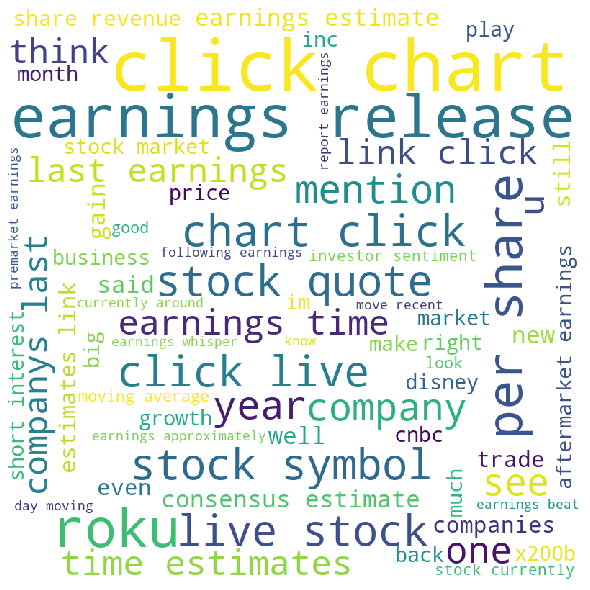

In [28]:
# This is for Reddit Data
print("This is Reddit Data's word cloud")

comment_words = ''
stopwords = set(STOPWORDS)
  
# iterate
for val in R_Word_Cloud_df.Combined_text_FinalClean:
      
    # typecaste each val to string
    val = str(val)
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "
  
wordcloud_pic = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 18).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_pic)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

This is Twitter Data's word cloud


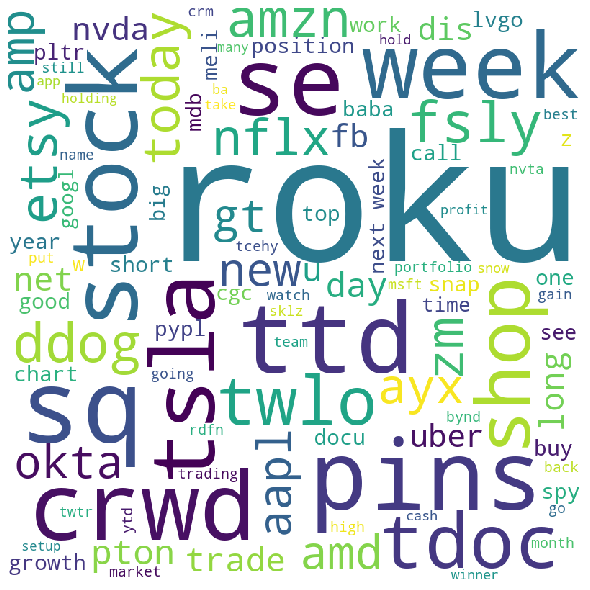

In [29]:
# This is Twitter Data's word cloud
print("This is Twitter Data's word cloud")

comment_words = ''
stopwords = set(STOPWORDS)
  
# iterate through the csv file
for val in T_Word_Cloud_df.tweet_FinalClean:
      
    # typecaste each val to string
    val = str(val)
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "
  
wordcloud_pic = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 18).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_pic)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

# Running the sentiment function to find sentiment scores

In [30]:
Sentiment_df['Score'] = Sentiment_df.Text.apply(lambda x: Sentiment(x))

In [31]:
Sentiment_df

,Date,Text,Score
0,2017-09-29,"$1900 in 10 minutes on $ROKU, so glad the mark...",0.8989
1,2017-09-29,$ROKU is already up almost 100% since its IPO....,0.0000
2,2017-09-30,Mystified by $ROKU's IPO? @JimCramer's breakin...,0.0000
3,2017-09-29,"$ROKU Long. One Ticker, a few trades. Couldve ...",0.5647
4,2017-09-29,Love #Pennystocks Nice Friday for my 2 account...,0.9222
...,...,...,...
673,2021-08-20,ROKU buy the dip? ROKU recently underperformed...,-0.4329
674,2021-08-27,"Here is a Market Recap for today Friday, Augus...",0.9879
675,2021-08-27,Compiling a list of subreddit for data analysi...,0.9510
676,2021-08-27,"Here is a Market Recap for today Friday, Augus...",0.9879


In [32]:
Text_to_check = Sentiment_df[Sentiment_df['Score'] == 0]
Text_to_check

,Date,Text,Score
1,2017-09-29,$ROKU is already up almost 100% since its IPO....,0.0
2,2017-09-30,Mystified by $ROKU's IPO? @JimCramer's breakin...,0.0
15,2017-12-08,$ROKU Next week there will be a big storm in S...,0.0
23,2017-12-22,First time since after $ROKU earnings in Nov n...,0.0
24,2017-12-30,"Oh, what a year. 📈 #BestOf2017 stocks from IB...",0.0
...,...,...,...
531,2021-01-20,$NFLX $DIS $ROKU Streaming Services Comparison...,0.0
555,2021-02-12,Earnings for the week of 2/15/2021 with Option...,0.0
631,2021-06-22,Weeklies for 6/25 Anyone open to throwing arou...,0.0
637,2021-06-24,$roku $tsla 160k total .,0.0


In [33]:
print('Texts from ',len(Text_to_check),' had a sentiment score of 0 (they analyzer did not understand or they were neutral).')
print('That is ', len(Text_to_check)/len(Sentiment_df)*100,'% of the entries we have.')

Texts from  183  had a sentiment score of 0 (they analyzer did not understand or they were neutral).
That is  14.219114219114218 % of the entries we have.


# Combining the scores for each day and combining all data to one dataframe

In [34]:
Sentiment_df.head()

,Date,Text,Score
0,2017-09-29,"$1900 in 10 minutes on $ROKU, so glad the mark...",0.8989
1,2017-09-29,$ROKU is already up almost 100% since its IPO....,0.0000
2,2017-09-30,Mystified by $ROKU's IPO? @JimCramer's breakin...,0.0000
3,2017-09-29,"$ROKU Long. One Ticker, a few trades. Couldve ...",0.5647
4,2017-09-29,Love #Pennystocks Nice Friday for my 2 account...,0.9222


In [35]:
Avg_Sentiment_df = Sentiment_df.groupby(['Date']).mean()

In [36]:
Avg_Sentiment_df.head()

,Score
Date,
2017-09-28,0.185700
2017-09-29,0.457833
2017-09-30,0.000000
2017-10-02,-0.094050
2017-10-05,-0.011300


In [37]:
len(Avg_Sentiment_df)

566

In [38]:
len(S_df)

988

In [39]:
S_df.head()

,Date,Open,High,Low,Close,Volume
0,2017-09-28,15.800000,23.500000,15.750000,23.500000,39265900
1,2017-09-29,26.740000,29.799999,25.469999,26.540001,44294700
2,2017-10-02,25.200001,26.280001,23.260000,23.559999,16008400
3,2017-10-03,23.010000,23.020000,20.770000,20.809999,13678500
4,2017-10-04,21.290001,22.600000,20.820000,20.850000,9345700


In [40]:
S_df_closing = S_df[['Date','Close']]
S_df_closing.head()

,Date,Close
0,2017-09-28,23.500000
1,2017-09-29,26.540001
2,2017-10-02,23.559999
3,2017-10-03,20.809999
4,2017-10-04,20.850000


In [41]:
Final_df = pd.merge(left=S_df_closing, right=Avg_Sentiment_df, how='left', left_on='Date', right_on='Date')
Final_df.columns = ['Date','Close','Sentiment_Score']
Final_df['Date'] = pd.to_datetime(Final_df['Date'])
Final_df.set_index('Date', inplace=True)
Final_df = Final_df.asfreq('B', method='ffill')
Final_df

,Close,Sentiment_Score
Date,,
2017-09-28,23.500000,0.185700
2017-09-29,26.540001,0.457833
2017-10-02,23.559999,-0.094050
2017-10-03,20.809999,NaN
2017-10-04,20.850000,NaN
...,...,...
2021-08-25,353.470001,NaN
2021-08-26,352.000000,NaN
2021-08-27,357.029999,0.975600


In [42]:
Final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1024 entries, 2017-09-28 to 2021-08-31
Freq: B
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Close            1024 non-null   float64
 1   Sentiment_Score  489 non-null    float64
dtypes: float64(2)
memory usage: 24.0 KB


In [43]:
Final_df.Close.isna().sum()

0

In [44]:
Final_df.head(75)

,Close,Sentiment_Score
Date,,
2017-09-28,23.500000,0.185700
2017-09-29,26.540001,0.457833
2017-10-02,23.559999,-0.094050
2017-10-03,20.809999,NaN
2017-10-04,20.850000,NaN
2017-10-05,22.010000,-0.011300
2017-10-06,23.200001,NaN
2017-10-09,24.540001,-0.938800
2017-10-10,22.930000,0.000000


Going to fill missing sentiment data by taking a gradient from last known sentiment to the next known sentiment.

In [45]:
Final_df['Sentiment_Score_LinearFill'] = Final_df['Sentiment_Score'].interpolate(method='linear')

In [46]:
# Making a logged closing cost since the data will most likely follow an exponential trend
Final_df['Close_logged'] = np.log(Final_df['Close'])

In [47]:
Final_df.tail(5)

,Close,Sentiment_Score,Sentiment_Score_LinearFill,Close_logged
Date,,,,
2021-08-25,353.470001,NaN,0.4122,5.867799
2021-08-26,352.000000,NaN,0.6939,5.863631
2021-08-27,357.029999,0.9756,0.9756,5.877820
2021-08-30,355.899994,0.8882,0.8882,5.874650
2021-08-31,352.399994,NaN,0.8882,5.864767


In [48]:
# Uncomment to run, this is for saving final df

#Final_df.to_csv(
#    path_or_buf='/Users/stevenkyle/Documents/Flatiron/Capstone/Capstone/FinalProcessedData.csv', index=True)

# Sentiment and Price correlation

In [49]:
# Creating dataframe to see if price goes up when sentiment is good and vice versa
Sentiment_Price_cor_df = Final_df[['Close', 'Sentiment_Score_LinearFill']]
Sentiment_Price_cor_df['Previous_Day_Sentiment'] = Sentiment_Price_cor_df['Sentiment_Score_LinearFill'].shift(1)
Sentiment_Price_cor_df['Previous_Day_Close'] = Sentiment_Price_cor_df['Close'].shift(1)
Sentiment_Price_cor_df['Day_Change'] = Sentiment_Price_cor_df['Close'] - Sentiment_Price_cor_df['Previous_Day_Close']
Sentiment_Price_cor_df.dropna(inplace=True)

/Users/stevenkyle/opt/anaconda3/envs/Capstone-new2/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
# Making columns to indicate if there was a positive of negative change

Senti_pos_neg = []
Price_pos_neg = []

for senti in Sentiment_Price_cor_df['Previous_Day_Sentiment']:
    if senti > 0:
        Senti_pos_neg.append('POS')
    elif senti < 0:
        Senti_pos_neg.append('NEG')
    elif senti ==0:
        Senti_pos_neg.append('NUE')
        
for price in Sentiment_Price_cor_df['Day_Change']:
    if price >0:
        Price_pos_neg.append('POS')
    elif price <0:
        Price_pos_neg.append('NEG')
    elif price ==0:
        Price_pos_neg.append('NUE')

Sentiment_Price_cor_df['Senti_pos_neg'] = Senti_pos_neg
Sentiment_Price_cor_df['Price_pos_neg'] = Price_pos_neg

In [51]:
# Now making a column to see if the price moved in the same direction with the sentiment
Direction = []

for i in range(len(Sentiment_Price_cor_df)):
               
    if (Sentiment_Price_cor_df.iloc[i]['Senti_pos_neg'] == Sentiment_Price_cor_df.iloc[i]['Price_pos_neg']):
        Direction.append('Sentiment Reflects Price Movement')
               
    elif (Sentiment_Price_cor_df.iloc[i]['Senti_pos_neg'] != Sentiment_Price_cor_df.iloc[i]['Price_pos_neg']):
        Direction.append('Sentiment Does Not Reflects Price Movement')

Sentiment_Price_cor_df['Same_Direction'] = Direction

In [52]:
Sentiment_Price_cor_df.head()

,Close,Sentiment_Score_LinearFill,Previous_Day_Sentiment,Previous_Day_Close,Day_Change,Senti_pos_neg,Price_pos_neg,Same_Direction
Date,,,,,,,,
2017-09-29,26.540001,0.457833,0.185700,23.500000,3.040001,POS,POS,Sentiment Reflects Price Movement
2017-10-02,23.559999,-0.094050,0.457833,26.540001,-2.980001,POS,NEG,Sentiment Does Not Reflects Price Movement
2017-10-03,20.809999,-0.066467,-0.094050,23.559999,-2.750000,NEG,NEG,Sentiment Reflects Price Movement
2017-10-04,20.850000,-0.038883,-0.066467,20.809999,0.040001,NEG,POS,Sentiment Does Not Reflects Price Movement
2017-10-05,22.010000,-0.011300,-0.038883,20.850000,1.160000,NEG,POS,Sentiment Does Not Reflects Price Movement


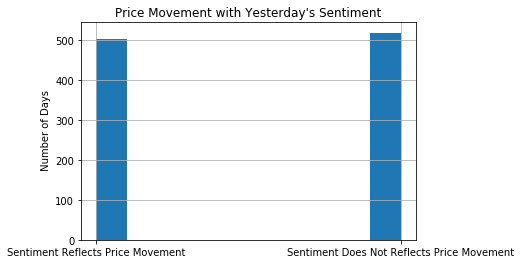

In [53]:
Sentiment_Price_cor_df.Same_Direction.hist();
plt.title("Price Movement with Yesterday's Sentiment");
plt.ylabel(" Number of Days");

In [54]:
# Dataframe for presentation
Sentiment_Price_Presi = Sentiment_Price_cor_df[['Close','Previous_Day_Sentiment','Senti_pos_neg','Price_pos_neg','Same_Direction']]
Sentiment_Price_Presi.columns = ['Close_Price',
                                 'Previous_Day_Sentiment',
                                 'Previous_Day_Sentiment_Pos/Neg',
                                 'Price_Change',
                                 'Comparison']

In [55]:
Sentiment_Price_Presi.head()

,Close_Price,Previous_Day_Sentiment,Previous_Day_Sentiment_Pos/Neg,Price_Change,Comparison
Date,,,,,
2017-09-29,26.540001,0.185700,POS,POS,Sentiment Reflects Price Movement
2017-10-02,23.559999,0.457833,POS,NEG,Sentiment Does Not Reflects Price Movement
2017-10-03,20.809999,-0.094050,NEG,NEG,Sentiment Reflects Price Movement
2017-10-04,20.850000,-0.066467,NEG,POS,Sentiment Does Not Reflects Price Movement
2017-10-05,22.010000,-0.038883,NEG,POS,Sentiment Does Not Reflects Price Movement


# Time series analysis for Stock Data

## Train test split, looking at original plot

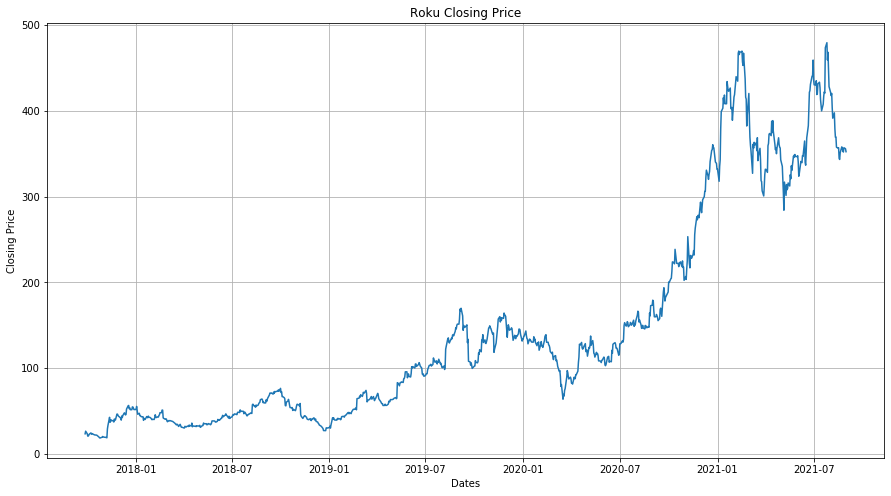

In [56]:
plt.figure(figsize = (15,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Price')
plt.plot(Final_df['Close'])
plt.title('Roku Closing Price')
plt.show()

In [57]:
# Train Test Split (Making testing data the last month)
Train, Test = train_test_split(Final_df, test_size=20)

In [58]:
Test

,Close,Sentiment_Score,Sentiment_Score_LinearFill,Close_logged
Date,,,,
2021-08-04,420.320007,0.877900,0.877900,6.041016
2021-08-05,403.480011,0.889833,0.889833,6.000127
2021-08-06,391.470001,0.999433,0.999433,5.969909
2021-08-09,397.730011,NaN,0.939556,5.985773
2021-08-10,379.260010,NaN,0.879678,5.938222
2021-08-11,369.209991,0.819800,0.819800,5.911366
2021-08-12,369.519989,NaN,0.670400,5.912205
2021-08-13,357.589996,0.521000,0.521000,5.879387
2021-08-16,356.579987,NaN,0.330220,5.876559


In [59]:
print('Train set has', len(Train),'entries.')
print('Test set has', len(Test),'entries.')

Train set has 1004 entries.
Test set has 20 entries.


## Looking at seasonality using Seasonal Decompose

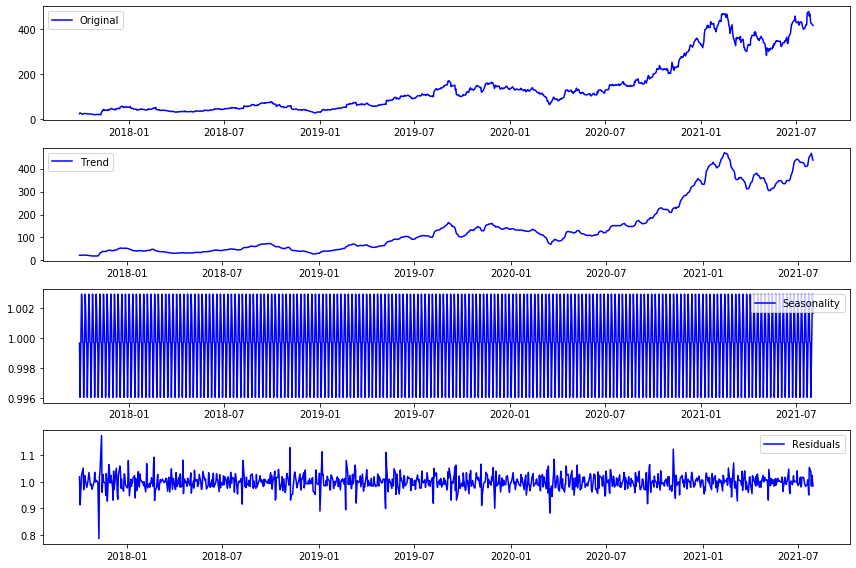

In [60]:
# Taking the decomposition of Roku Stock, the original plot sugests a multiplicative trend.
decomposition = seasonal_decompose(Train['Close'], model='multiplicative')

# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting the original data
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(Train['Close'], label='Original', color='blue')
plt.legend(loc='best')

# Plotting the Trend of the data
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')

# Plotting the Seasonality of the data
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')

# Plotting the Residuals of the data
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [61]:
seasonal

Date
2017-09-28    0.999664
2017-09-29    0.996076
2017-10-02    1.002904
2017-10-03    1.001643
2017-10-04    0.999712
                ...   
2021-07-28    0.999712
2021-07-29    0.999664
2021-07-30    0.996076
2021-08-02    1.002904
2021-08-03    1.001643
Freq: B, Name: Close, Length: 1004, dtype: float64

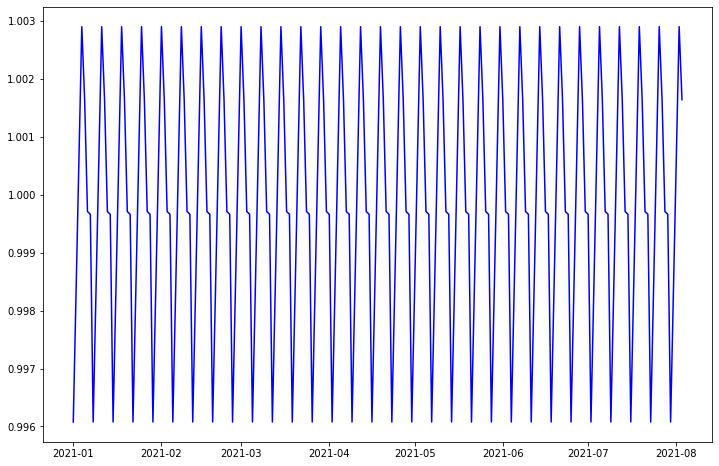

In [62]:
# Zoom up on seasonal trends
plt.figure(figsize=(12,8))
plt.plot(seasonal['2021':], label='Original', color='blue')
plt.show()

The time difference between the two minimums is 7 days 00:00:00


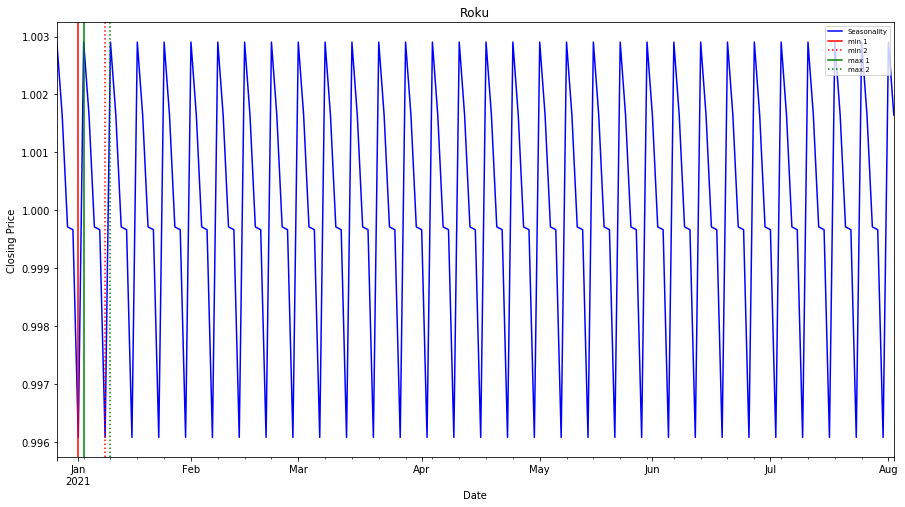

In [63]:
# Looking at the seasonal plot closer
plt.figure(figsize=(15,8))

# Plotting the seasonality plot
ax = seasonal['2020-12-27':].plot(label='Seasonality', color='blue')

# Finding the time stamps of the mins and maxs
min_ = seasonal['2021':].idxmin()
max_ = seasonal['2021':].idxmax()
min_2 = seasonal[max_:].idxmin()
max_2 = seasonal[min_2:].idxmax()

# Adding verticle lines for the mins/maxs
ax.axvline(min_,label='min 1',c='red')
ax.axvline(min_2,label='min 2',c='red', ls=':')
ax.axvline(max_,label='max 1',c='green')
ax.axvline(max_2,label='max 2',c='green', ls=':')

# Graph properties
plt.legend(loc='upper right', fontsize='x-small')
plt.xlabel('Date')
plt.title('Roku')
plt.ylabel('Closing Price')

print(f'The time difference between the two minimums is {min_2-min_}')

The seasonality seems to happen every week, however the change in price is very miniscule. The seasonality factor can most likely be ignored.

## Arima Modeling

### Auto Arima on raw data

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6792.782, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6793.617, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6793.766, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6793.820, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6796.227, Time=0.91 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.054 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1004
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3394.391
Date:                Thu, 07 Oct 2021   AIC                           6792.782
Time:                        18:50:27   BIC                           6802.603
Sample:                             0   HQIC                          6796.514
                               - 1004                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3931      0.228      1.724      0.085      -0.054       0.840
sigma2        50.9375      1.016     50.131      0.000      48.946      52.929
===================================================================================
Ljung-Box (Q):                       78.26   Jarque-Bera (JB):              2893.25
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              23.01   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

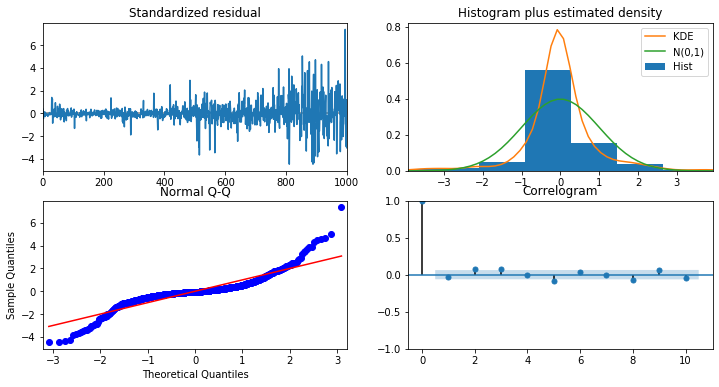

In [64]:
# Running auto_arima
auto_model = pm.auto_arima(y=Train['Close'], start_p=0, start_q=0, max_p=5, max_q=5, m=1,
                           seasonal=False, max_order=None,trace=True)

# Plotting auto_arima summary
display(auto_model.summary())

# Plotting auto_arima diagnostics
auto_model.plot_diagnostics(figsize=(12,6));

### Auto Arima on logged data

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3229.436, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3227.840, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3227.783, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3227.899, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3228.032, Time=2.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 3.794 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1004
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1616.718
Date:                Thu, 07 Oct 2021   AIC                          -3229.436
Time:                        18:50:52   BIC                          -3219.615
Sample:                             0   HQIC                         -3225.704
                               - 1004                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0029      0.002      1.829      0.067      -0.000       0.006
sigma2         0.0023   4.22e-05     55.286      0.000       0.002       0.002
===================================================================================
Ljung-Box (Q):                       29.68   Jarque-Bera (JB):              5096.65
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

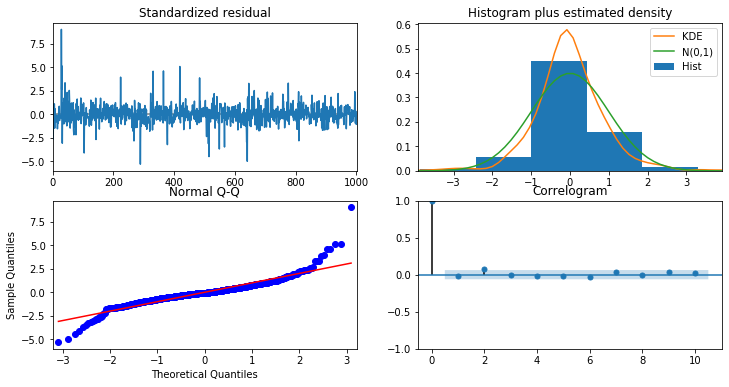

In [65]:
# Running auto_arima
auto_model = pm.auto_arima(y=Train['Close_logged'], start_p=0, start_q=0, max_p=5, max_q=5, m=1,
                           seasonal=False, max_order=None,trace=True)

# Plotting auto_arima summary
display(auto_model.summary())

# Plotting auto_arima diagnostics
auto_model.plot_diagnostics(figsize=(12,6));

The scores of the AIC look very close together, to further investigate we're going to check the parameters manually.

### Checking stationarity with diff 1 on raw and logged data.

In [66]:
# Taking a difference of one on raw data
Train_Close_diff1 = Train['Close'].diff(1).dropna()

print("Results of dickey fuller test for raw data")
adft = adfuller(Train_Close_diff1, autolag='AIC')

output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
print(output)

Results of dickey fuller test for raw data
Test Statistics               -1.429174e+01
p-value                        1.272178e-26
No. of lags used               4.000000e+00
Number of observations used    9.980000e+02
critical value (1%)           -3.436919e+00
critical value (5%)           -2.864440e+00
critical value (10%)          -2.568314e+00
dtype: float64


In [67]:
# Taking a difference of one on logged data
Train_Close_logged_diff1 = Train['Close_logged'].diff(1).dropna()

print("Results of dickey fuller test for logged data")
adft = adfuller(Train_Close_logged_diff1, autolag='AIC')

output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
print(output)

Results of dickey fuller test for logged data
Test Statistics                 -20.746851
p-value                           0.000000
No. of lags used                  1.000000
Number of observations used    1001.000000
critical value (1%)              -3.436900
critical value (5%)              -2.864432
critical value (10%)             -2.568310
dtype: float64


A difference of 1 will makes both time series stationary.

### PACF and ACF plots

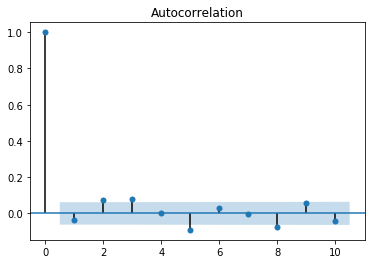

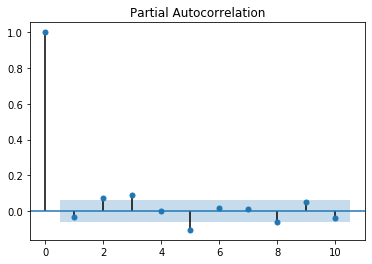

In [68]:
plot_acf(Train_Close_diff1, lags=10);
plot_pacf(Train_Close_diff1, lags=10);

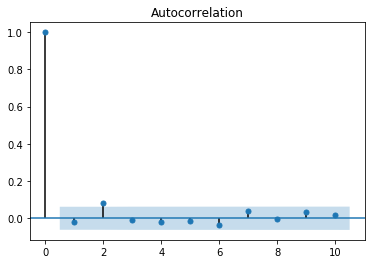

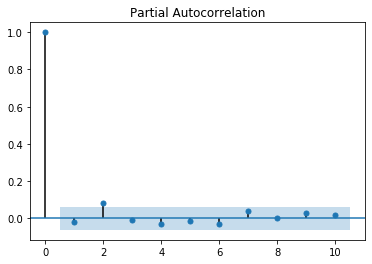

In [69]:
plot_acf(Train_Close_logged_diff1, lags=10);
plot_pacf(Train_Close_logged_diff1, lags=10);

### Trying order list found from PACF and ACF

In [70]:
# Trying different sets of parameters on raw data
order_list = [(0,1,0),(3,1,0),(0,1,3),(3,1,3)]

possible_params = Grid_Auto_bot(data = Train['Close'], order_list=order_list)
print('This is for the raw data')

# Ordering the parameters by aic
possible_params.sort_values(by='aic', ascending=True, inplace=True)
raw_order_1 = possible_params.iloc[0]['pdq']
raw_order_2 = possible_params.iloc[1]['pdq']
possible_params.head()

ARIMA (0, 1, 0) : AIC Calculated =6792.7817035003445
ARIMA (3, 1, 0) : AIC Calculated =6784.893098358476
ARIMA (0, 1, 3) : AIC Calculated =6782.539300944798
ARIMA (3, 1, 3) : AIC Calculated =6783.819025420216
This is for the raw data


,pdq,aic
2,"(0, 1, 3)",6782.539301
3,"(3, 1, 3)",6783.819025
1,"(3, 1, 0)",6784.893098
0,"(0, 1, 0)",6792.781704


In [71]:
# Trying different set of params on logged data
order_list = [(0,1,0),(2,1,0),(0,1,2),(2,1,2)]

possible_params = Grid_Auto_bot(data = Train['Close_logged'], order_list=order_list)
print('This is for the logged data')

# Ordering the parameters by aic
possible_params.sort_values(by='aic', ascending=True, inplace=True)
logged_order_1 = possible_params.iloc[0]['pdq']
logged_order_2 = possible_params.iloc[1]['pdq']
possible_params.head()

ARIMA (0, 1, 0) : AIC Calculated =-3229.4360136139767
ARIMA (2, 1, 0) : AIC Calculated =-3232.604607239257
ARIMA (0, 1, 2) : AIC Calculated =-3232.8958177499585
ARIMA (2, 1, 2) : AIC Calculated =-3229.0587036192924
This is for the logged data


,pdq,aic
2,"(0, 1, 2)",-3232.895818
1,"(2, 1, 0)",-3232.604607
0,"(0, 1, 0)",-3229.436014
3,"(2, 1, 2)",-3229.058704


### Modeling using the new parameters

#### RAW DATA

##### First Parameter

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 1003
Model:                 ARIMA(0, 1, 3)   Log Likelihood               -3386.270
Method:                       css-mle   S.D. of innovations              7.079
Date:                Thu, 07 Oct 2021   AIC                           6782.539
Time:                        19:01:24   BIC                           6807.093
Sample:                    09-29-2017   HQIC                          6791.870
                         - 08-03-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3894      0.256      1.519      0.129      -0.113       0.892
ma.L1.D.Close    -0.0377      0.031     -1.205      0.228      -0.099       0.024
ma.L2.D.Close     0.0923      0.032      2.901      0.004       0.030       0.155
ma.L3.D.Close     0.0927      0.031      3.007      0.003       0.032       0.153
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            0.8352           -1.8303j            2.0118           -0.1819
MA.2            0.8352           +1.8303j            2.0118            0.1819
MA.3           -2.6664           -0.0000j            2.6664           -0.5000
-----------------------------------------------------------------------------
"""

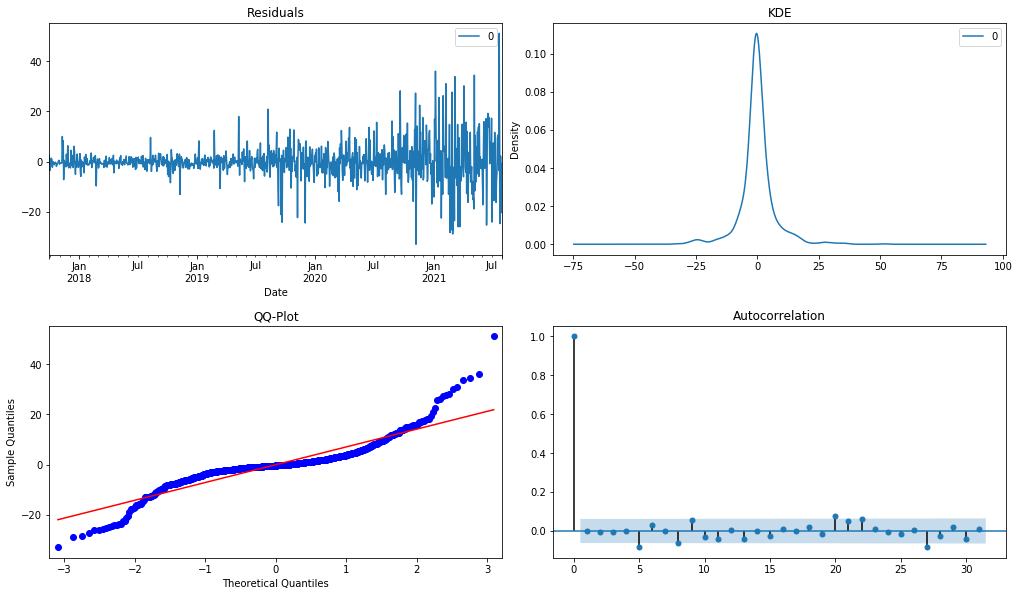

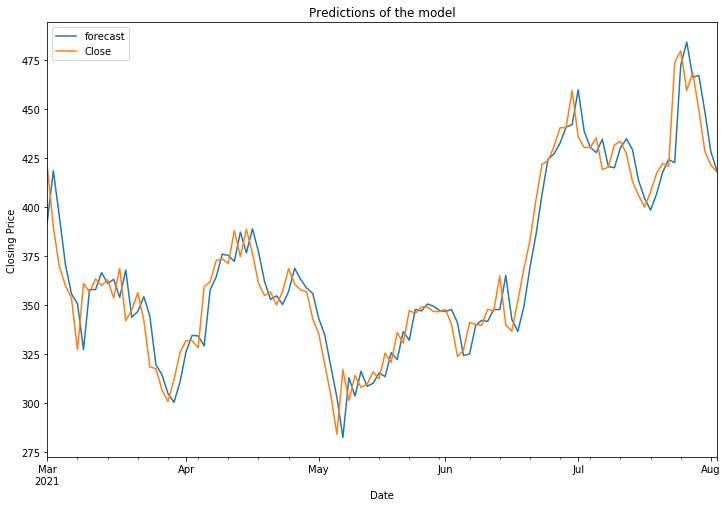

In [72]:
# Testing the First set of parameters
ArimaModelDiagnostics(Train['Close'], order=raw_order_1, pred_start='2021-03-01')

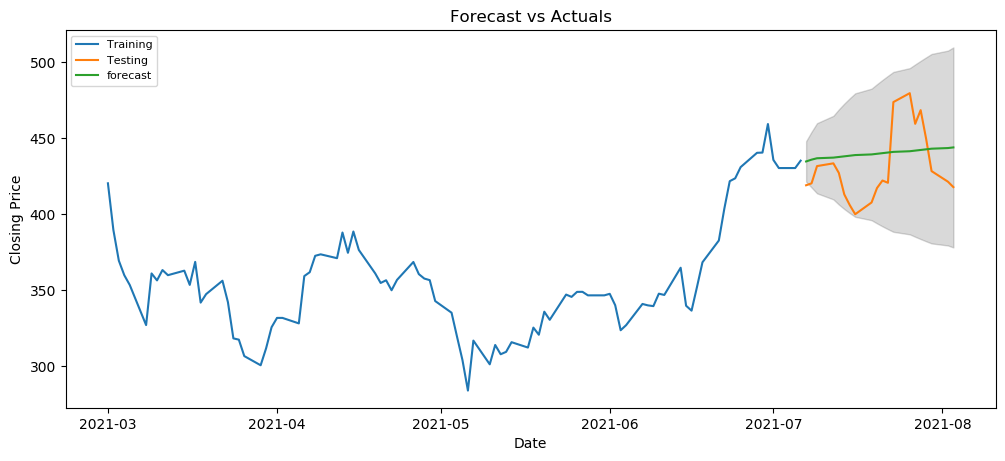

MSE was  549.7816006840762 and rmse was 23.44742204772363


In [73]:
ArimaSubsetTest(Train['Close'], order=raw_order_1, test_size=20, plot_start='2021-03-01')

##### Second Parameter

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 1003
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -3383.910
Method:                       css-mle   S.D. of innovations              7.063
Date:                Thu, 07 Oct 2021   AIC                           6783.819
Time:                        19:06:41   BIC                           6823.105
Sample:                    09-29-2017   HQIC                          6798.748
                         - 08-03-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3884      0.248      1.565      0.118      -0.098       0.875
ar.L1.D.Close     0.0298      0.231      0.129      0.897      -0.423       0.483
ar.L2.D.Close    -0.4331      0.133     -3.253      0.001      -0.694      -0.172
ar.L3.D.Close     0.3073      0.180      1.705      0.089      -0.046       0.661
ma.L1.D.Close    -0.0611      0.237     -0.258      0.796      -0.525       0.403
ma.L2.D.Close     0.5014      0.130      3.855      0.000       0.246       0.756
ma.L3.D.Close    -0.2199      0.186     -1.182      0.238      -0.585       0.145
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.3456           -1.1957j            1.2447           -0.2948
AR.2           -0.3456           +1.1957j            1.2447            0.2948
AR.3            2.1007           -0.0000j            2.1007           -0.0000
MA.1           -0.2459           -1.2570j            1.2808           -0.2807
MA.2           -0.2459           +1.2570j            1.2808            0.2807
MA.3            2.7714           -0.0000j            2.7714           -0.0000
-----------------------------------------------------------------------------
"""

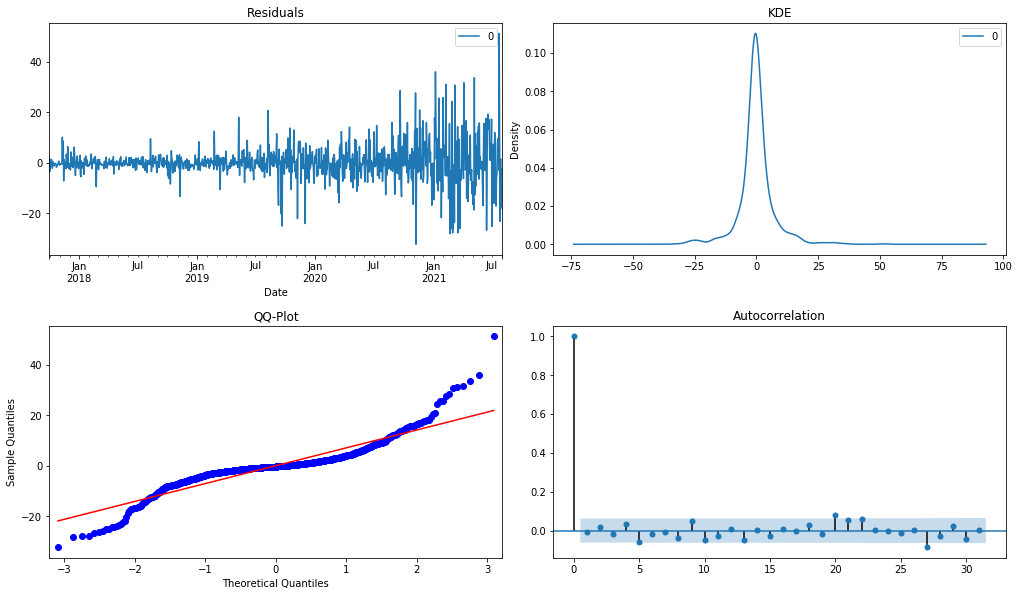

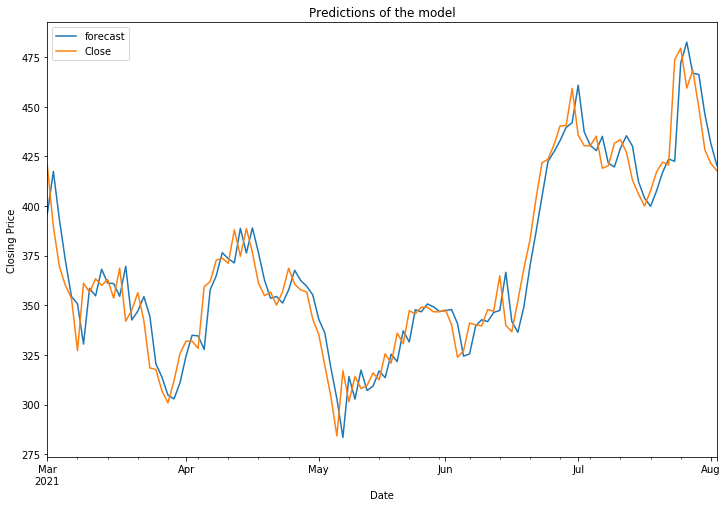

In [74]:
# Testing the Second set of parameters
ArimaModelDiagnostics(Train['Close'], order=raw_order_2, pred_start='2021-03-01')

In [75]:
ArimaSubsetTest(Train['Close'], order=raw_order_2, test_size=20, plot_start='2021-03-01')

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

##### Final Model, test predictions

The parameters that will be used is the second parameter. The difference between the two parameters are miniscule but the second parameter is a little simpler and also had slightly less error.

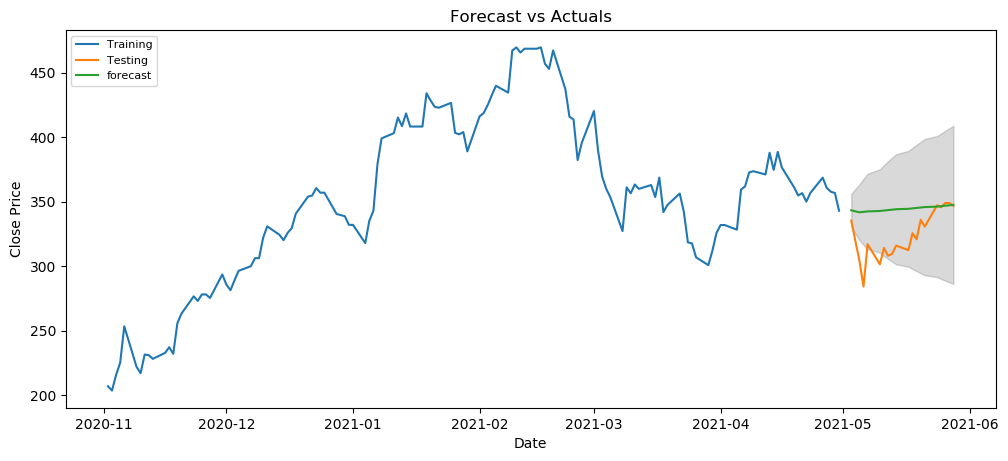

MSE was  705.3375501054053 and rmse was 26.558191770250573


In [64]:
ArimaTestForecast(train=Train['Close'], test=Test['Close'], 
                  order=raw_order_2, test_size=20, plot_start='2020-11-01', logged=False)

#### LOGGED DATA

##### First Parameter

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.Close_logged   No. Observations:                  936
Model:                 ARIMA(0, 1, 2)   Log Likelihood                1497.566
Method:                       css-mle   S.D. of innovations              0.049
Date:                Thu, 24 Jun 2021   AIC                          -2987.132
Time:                        21:33:48   BIC                          -2967.766
Sample:                    09-29-2017   HQIC                         -2979.748
                         - 04-30-2021                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0029      0.002      1.677      0.094      -0.000       0.006
ma.L1.D.Close_logged    -0.0165      0.033     -0.506      0.613      -0.081       0.047
ma.L2.D.Close_logged     0.0839      0.033      2.509      0.012       0.018       0.149
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            0.0984           -3.4512j            3.4526           -0.2455
MA.2            0.0984           +3.4512j            3.4526            0.2455
-----------------------------------------------------------------------------
"""

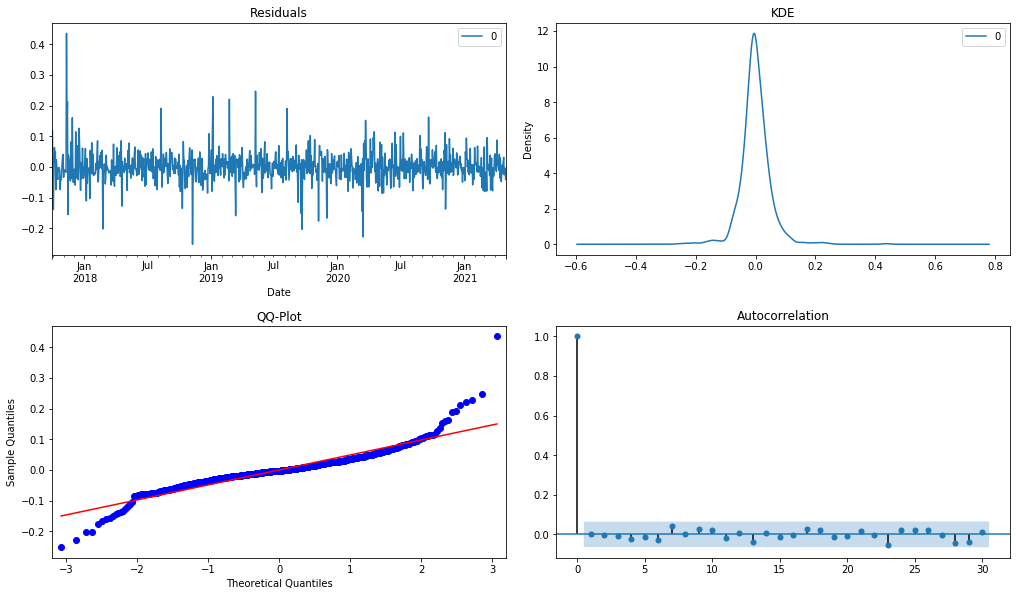

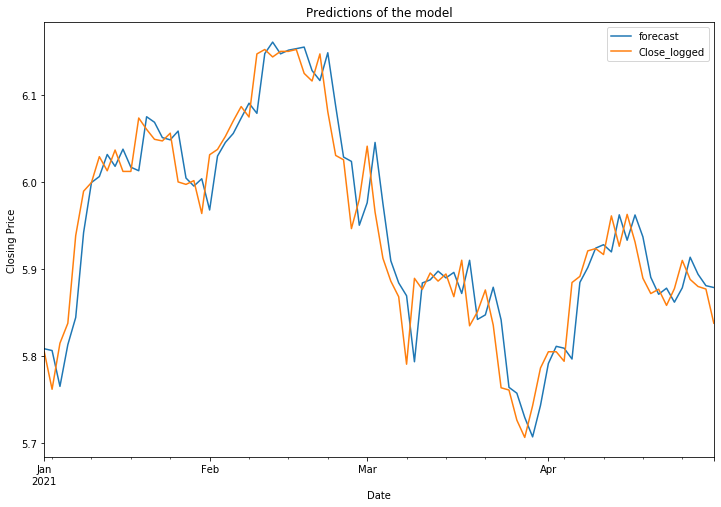

In [65]:
# Testing the First set of parameters
ArimaModelDiagnostics(Train['Close_logged'], order=logged_order_1, pred_start='2021-01-01')

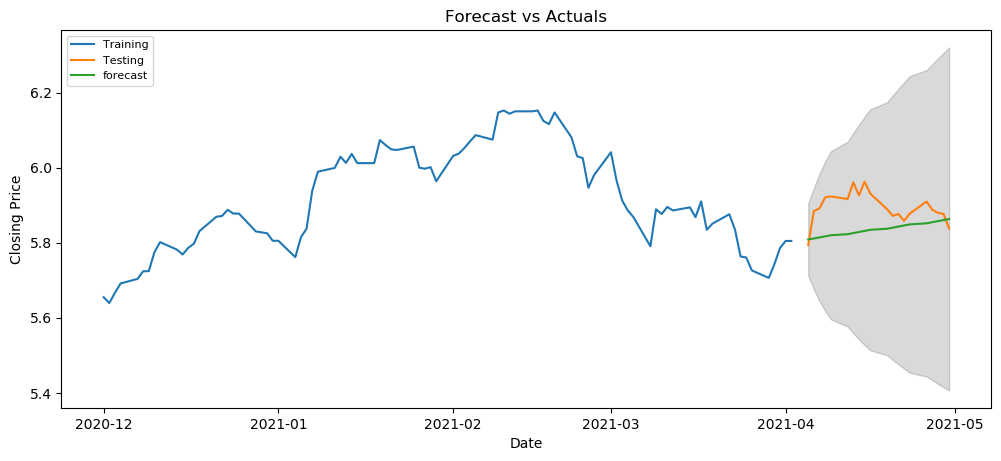

MSE was  686.9214628247762 and rmse was 26.209186611277662


In [66]:
ArimaSubsetTest(Train['Close_logged'], order=logged_order_1, test_size=20,
                plot_start='2020-12-01', logged=True)

##### Second Parameter

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.Close_logged   No. Observations:                  936
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1497.425
Method:                       css-mle   S.D. of innovations              0.049
Date:                Thu, 24 Jun 2021   AIC                          -2986.849
Time:                        21:33:49   BIC                          -2967.483
Sample:                    09-29-2017   HQIC                         -2979.465
                         - 04-30-2021                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0029      0.002      1.679      0.093      -0.000       0.006
ar.L1.D.Close_logged    -0.0178      0.033     -0.545      0.586      -0.082       0.046
ar.L2.D.Close_logged     0.0796      0.033      2.428      0.015       0.015       0.144
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.4349           +0.0000j            3.4349            0.5000
AR.2            3.6586           +0.0000j            3.6586            0.0000
-----------------------------------------------------------------------------
"""

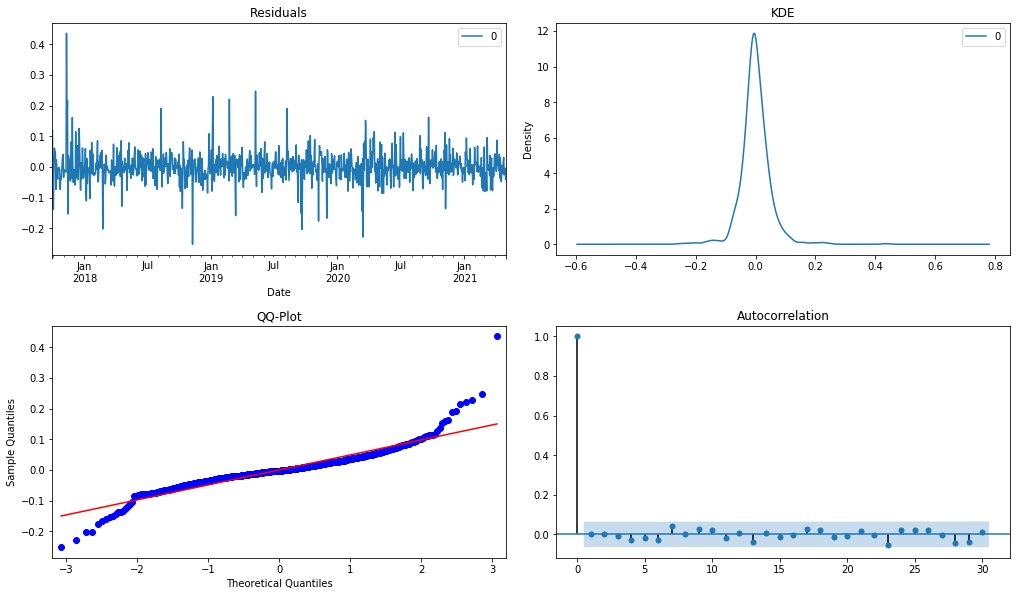

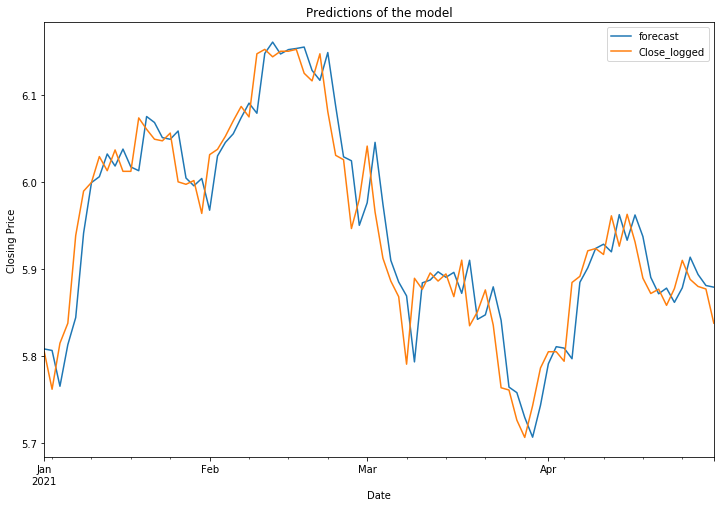

In [67]:
# Testing the Second set of parameters
ArimaModelDiagnostics(Train['Close_logged'], order=logged_order_2, pred_start='2021-01-01')

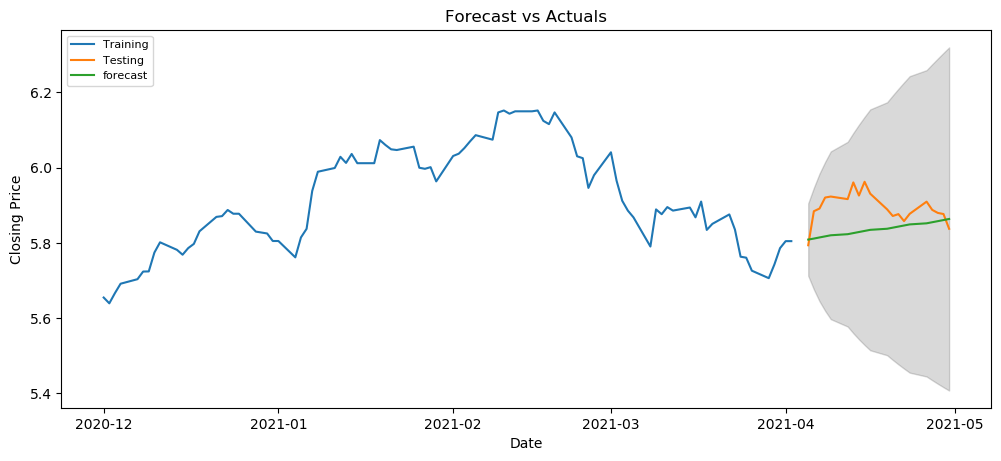

MSE was  680.8478480612446 and rmse was 26.09306130106708


In [68]:
ArimaSubsetTest(Train['Close_logged'], order=logged_order_2, test_size=20,
                plot_start='2020-12-01', logged=True)

##### Final Model, test predictions

Going with the second parameters, the difference wasn't that great and the error rate was less for the second parameter.

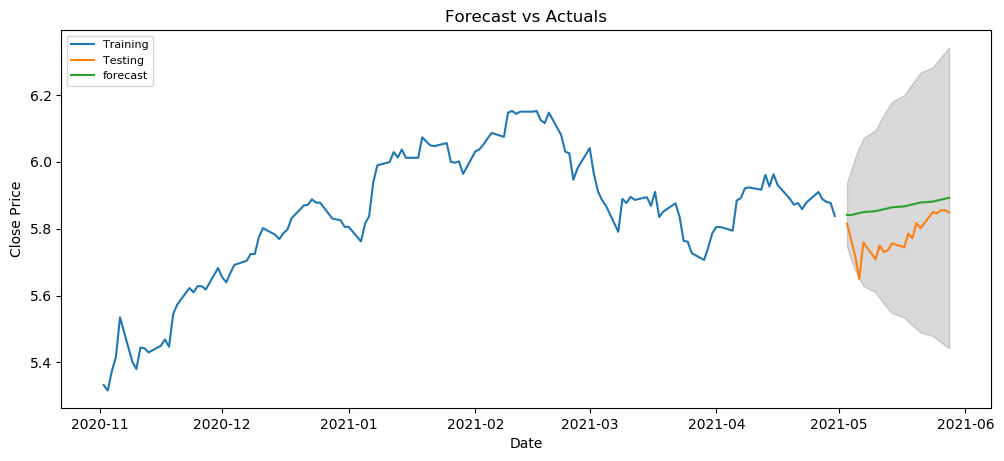

MSE was  1041.1354370530955 and rmse was 32.26663039508612


In [69]:
ArimaTestForecast(train=Train['Close_logged'], test=Test['Close_logged'], 
                  order=raw_order_2, test_size=20, plot_start='2020-11-01', logged=True)

## LSTM Modeling Single Step

In [70]:
# Creating supervised learning set for LSTM
Supervised_LSTM_Data = pd.DataFrame(Final_df['Close'])
Supervised_LSTM_Data['Shifted_Close'] = Supervised_LSTM_Data['Close'].shift(1)
Supervised_LSTM_Data.fillna(0, inplace=True)
Supervised_LSTM_Data.columns = ['Y','X']
Supervised_LSTM_Data = Supervised_LSTM_Data[['X','Y']]
Supervised_LSTM_Data.head()

,X,Y
Date,,
2017-09-28,0.000000,23.500000
2017-09-29,23.500000,26.540001
2017-10-02,26.540001,23.559999
2017-10-03,23.559999,20.809999
2017-10-04,20.809999,20.850000


In [71]:
# Train test split, the test size is the latest 20 days in the data that was collected
Supervised_LSTM_Data_Values = Supervised_LSTM_Data.values
train, test = Supervised_LSTM_Data_Values[0:-20], Supervised_LSTM_Data_Values[-20:]
print('Training shape:',train.shape)
print('Testing shape:', test.shape)

Training shape: (937, 2)
Testing shape: (20, 2)


In [72]:
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled


In [73]:
# Scaling the train and test set so that it is between -1 and 1
scaler, train_scaled, test_scaled = scale(train, test)

In [74]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(
                   batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [75]:
# Making initial model
trial_model = fit_lstm(train=train_scaled, batch_size=1, nb_epoch=100 ,neurons=4)

In [76]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [77]:
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [78]:
# The raw closing costs
raw_values = Final_df['Close']

In [79]:
# One step forecast for this LSTM
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(trial_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    # yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i ]
    print('Days=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Days=1, Predicted=366.488780, Expected=335.309998
Days=2, Predicted=352.638625, Expected=319.589996
Days=3, Predicted=333.612004, Expected=304.170013
Days=4, Predicted=312.932119, Expected=284.179993
Days=5, Predicted=287.816125, Expected=317.000000
Days=6, Predicted=328.424607, Expected=301.410004
Days=7, Predicted=304.705885, Expected=314.119995
Days=8, Predicted=322.560550, Expected=308.029999
Days=9, Predicted=316.246143, Expected=309.600006
Days=10, Predicted=321.668177, Expected=315.950012
Days=11, Predicted=327.971755, Expected=312.429993
Days=12, Predicted=326.389984, Expected=325.529999
Days=13, Predicted=336.741915, Expected=320.839996
Days=14, Predicted=333.552048, Expected=335.980011
Days=15, Predicted=344.869821, Expected=330.649994
Days=16, Predicted=341.477805, Expected=347.220001
Days=17, Predicted=353.468978, Expected=345.700012
Days=18, Predicted=352.929939, Expected=348.989990
Days=19, Predicted=356.491083, Expected=349.029999
Days=20, Predicted=356.833796, Expected=

Test RMSE: 18.284


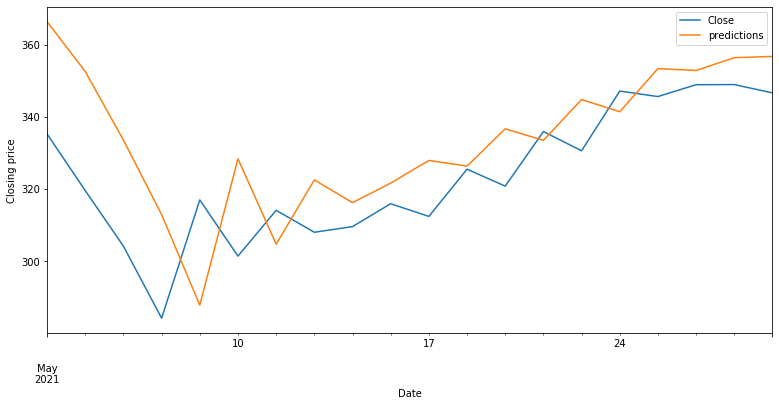

In [80]:
# Performance report
rmse = sqrt(mean_squared_error(raw_values[-20:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
temp_df = pd.DataFrame(raw_values[-20:])
temp_df['predictions'] = predictions
temp_df.plot(legend=True, figsize=(13,6))
plt.ylabel('Closing price')
plt.show()

# Time series modeling with chosen model

The untuned LSTM Modeling did better than the ARIMA modeling, LSTM modeling will be used.

## Tuning LSTM Model

In [81]:
def LSTM_Tuning(train_scaled, train, test_scaled, raw_values,
                scaler, nb_epoch_list, neurons_list):
    results_df = pd.DataFrame()
    #results_df.columns = ['nb_epoch','neurons','rmse']
    nb_epoch_report = []
    neurons_report = []
    rmse_report = []
    for k in range(len(nb_epoch_list)):
        for j in range(len(neurons_list)):
            # Making initial model
            trial_model = fit_lstm(train=train_scaled, batch_size=1,
                                   nb_epoch=nb_epoch_list[k] ,neurons=neurons_list[j])

            # One step forecast for this LSTM
            predictions = list()
            for i in range(len(test_scaled)):
                # make one-step forecast
                X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
                yhat = forecast_lstm(trial_model, 1, X)
                # invert scaling
                yhat = invert_scale(scaler, X, yhat)
                # store forecast
                predictions.append(yhat)
                expected = raw_values[len(train) + i ]

            # Performance report
            rmse = sqrt(mean_squared_error(raw_values[-20:], predictions))
            nb_epoch_report.append(nb_epoch_list[k])
            neurons_report.append(neurons_list[j])
            rmse_report.append(rmse)
            print('On model nb_epoch', nb_epoch_list[k], 'and neuron', neurons_list[j] )
            
    results_df['nb_epoch'] = nb_epoch_report
    results_df['neurons'] = neurons_report
    results_df['rmse'] = rmse_report
    
    return results_df

In [82]:
# Tuning LSTM

# parameter_tune_df = LSTM_Tuning(train_scaled = train_scaled, train = train,
#                                 test_scaled = test_scaled , raw_values = raw_values,
#                                 scaler = scaler,
#                                 nb_epoch_list = [10, 50, 100, 200],
#                                 neurons_list= [1, 2, 3, 4])

In [83]:
# Saved to a csv file so will not have to run the tuning everytime notebook is ran
# parameter_tune_df.to_csv(path_or_buf='/Users/stevenkyle/Documents/Flatiron/Capstone/Capstone/LSTM_Tuning.csv',index=False)

In [84]:
Tuning_df = pd.read_csv('LSTM_Tuning.csv')
Tuning_df

,nb_epoch,neurons,rmse
0,10,1,20.585930
1,10,2,13.193887
2,10,3,19.878312
3,10,4,14.235723
4,50,1,14.293844
5,50,2,14.035040
6,50,3,14.900249
7,50,4,12.610404
8,100,1,15.919147
9,100,2,14.835131


In [85]:
Tuning_df.sort_values(by='rmse', axis=0, ascending=True, inplace=True)
Tuning_df.iloc[0]

nb_epoch    50.000000
neurons      4.000000
rmse        12.610404
Name: 7, dtype: float64

The best number of epochs and neurons is 50 epochs and 4 neurons.

## Creating final LSTM Model

Days=1, Predicted=293.066319, Expected=335.309998
Days=2, Predicted=326.786643, Expected=319.589996
Days=3, Predicted=331.610677, Expected=304.170013
Days=4, Predicted=321.309385, Expected=284.179993
Days=5, Predicted=302.848087, Expected=317.000000
Days=6, Predicted=314.489643, Expected=301.410004
Days=7, Predicted=308.857770, Expected=314.119995
Days=8, Predicted=314.707959, Expected=308.029999
Days=9, Predicted=313.284593, Expected=309.600006
Days=10, Predicted=313.810658, Expected=315.950012
Days=11, Predicted=318.196824, Expected=312.429993
Days=12, Predicted=317.780024, Expected=325.529999
Days=13, Predicted=326.211397, Expected=320.839996
Days=14, Predicted=326.645057, Expected=335.980011
Days=15, Predicted=336.443221, Expected=330.649994
Days=16, Predicted=336.807452, Expected=347.220001
Days=17, Predicted=346.649257, Expected=345.700012
Days=18, Predicted=348.874654, Expected=348.989990
Days=19, Predicted=351.044297, Expected=349.029999
Days=20, Predicted=351.498701, Expected=

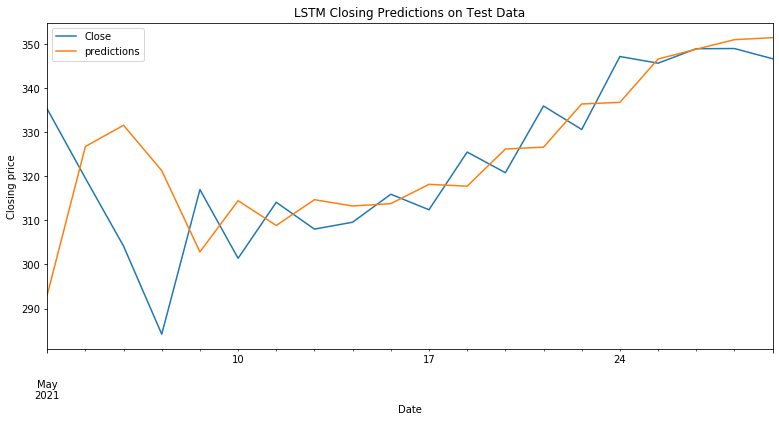

In [86]:
# Creating Model
Final_LSTM_model = fit_lstm(train=train_scaled, batch_size=1, nb_epoch=50 ,neurons=4)

# One step forecast for this LSTM
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(Final_LSTM_model, 1, X)
    
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i ]
    print('Days=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
    
# Performance report
rmse = sqrt(mean_squared_error(raw_values[-20:], predictions))
print('Test RMSE: %.3f' % rmse)

# line plot of observed vs predicted
temp_df = pd.DataFrame(raw_values[-20:])
temp_df['predictions'] = predictions
temp_df.plot(legend=True, figsize=(13,6))
plt.title('LSTM Closing Predictions on Test Data')
plt.ylabel('Closing price')
plt.show()

In [212]:
# Creating Train Predictions
train_predictions = list()
for i in range(len(train_scaled[-30:])):
    # make one-step forecast
    X, y = train_scaled[-30:][i, 0:-1], train_scaled[-30:][i, -1]
    yhat = forecast_lstm(Final_LSTM_model, 1, X)
    
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    
    # store forecast
    train_predictions.append(yhat)

train_predictions

[351.0595562816665,
 353.7275269295655,
 347.71826050769704,
 334.02167845747493,
 329.3242270128598,
 322.7595187880451,
 317.41760803564733,
 320.0922607104159,
 327.29853762776787,
 332.9336508791043,
 335.01419473024856,
 333.9861306123175,
 349.8083366667901,
 356.5358873653367,
 363.8999448185605,
 367.05856715374244,
 366.71943748420705,
 374.91375358188276,
 371.381583088662,
 376.6274985254682,
 372.99591775724963,
 363.66277992121655,
 357.4744701355199,
 356.25275496322973,
 352.49297877005796,
 354.49844729315413,
 361.11952251525423,
 359.31435346158156,
 357.14270817367975,
 356.05889551567856]

In [215]:
Training_predictions_df = pd.DataFrame(raw_values[-50:-20])
Training_predictions_df['Train_predictions'] = train_predictions

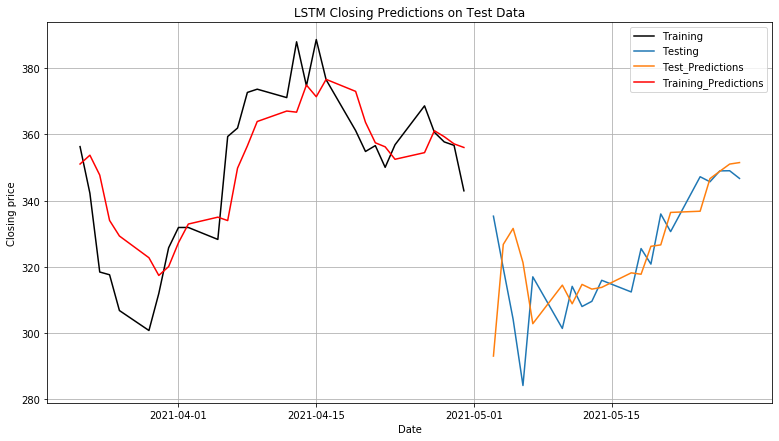

In [222]:
plt.figure(figsize=(13,7))
plt.plot(raw_values[-50:-20], label='Training', color='black')
temp_df = pd.DataFrame(raw_values[-20:])
temp_df['predictions'] = predictions
plt.plot(temp_df['Close'], label='Testing')
plt.plot(temp_df['predictions'], label='Test_Predictions')
plt.plot(Training_predictions_df['Train_predictions'], label='Training_Predictions', color='red')
plt.plot()
plt.title('LSTM Closing Predictions on Test Data')
plt.legend()
plt.ylabel('Closing price')
plt.xlabel('Date')
plt.grid()
plt.show()

In [223]:
# # Saving Model
# filename = 'Single_LSTM_model.sav'
# pickle.dump(Final_LSTM_model, open(filename, 'wb'))

# Time series modeling on Roku with Sentiment Analysis

In [88]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

In [89]:
# Creating supervised learning set for LSTM
Sentiment_Data = Final_df['Sentiment_Score_LinearFill'].shift(1)
Sentiment_Data = Sentiment_Data.fillna(0)
Sentiment_Stock_Data = Supervised_LSTM_Data.copy()
Sentiment_Stock_Data['Sentiment'] = Sentiment_Data
Sentiment_Stock_Data.columns = ['X1','Y','X2']
Supervised_Sentiment_LSTM_Data = Sentiment_Stock_Data[['X1','X2','Y']]
Supervised_Sentiment_LSTM_Data.head()

,X1,X2,Y
Date,,,
2017-09-28,0.000000,0.000000,23.500000
2017-09-29,23.500000,0.185700,26.540001
2017-10-02,26.540001,0.457833,23.559999
2017-10-03,23.559999,-0.094050,20.809999
2017-10-04,20.809999,-0.066467,20.850000


In [90]:
# Train test split, the test size is the latest 20 days in the data that was collected
Supervised_Sentiment_LSTM_Data_Values = Supervised_Sentiment_LSTM_Data.values
Multi_train, Multi_test = Supervised_Sentiment_LSTM_Data_Values[0:-20], Supervised_Sentiment_LSTM_Data_Values[-20:]
print('Training shape:', Multi_train.shape)
print('Testing shape:', Multi_test.shape)

Training shape: (937, 3)
Testing shape: (20, 3)


In [91]:
# Scaling
Multi_scaler, Multi_train_scaled, Multi_test_scaled = scale(Multi_train, Multi_test)

In [92]:
# split into input and outputs
Multi_train_X, Multi_train_y = Multi_train_scaled[:, :-1], Multi_train_scaled[:, -1]
Multi_test_X, Multi_test_y = Multi_test_scaled[:, :-1], Multi_test_scaled[:, -1]

# reshape input to be 3D [samples, timesteps, features]
Multi_train_X = Multi_train_X.reshape((Multi_train_X.shape[0], 1, Multi_train_X.shape[1]))
Multi_test_X = Multi_test_X.reshape((Multi_test_X.shape[0], 1, Multi_test_X.shape[1]))
print(Multi_train_X.shape, Multi_train_y.shape, Multi_test_X.shape, Multi_test_y.shape)

(937, 1, 2) (937,) (20, 1, 2) (20,)


In [94]:
Multi_model = Sequential()
Multi_model.add(LSTM(4, input_shape=(Multi_train_X.shape[1],
                                           Multi_train_X.shape[2])))
Multi_model.add(Dense(1))
Multi_model.compile(loss='mean_squared_error', optimizer='adam')
Multi_model.fit(Multi_train_X, Multi_train_y, epochs=50,
                    batch_size=1, validation_data=(Multi_test_X,Multi_test_y), verbose=0, shuffle=False)

In [95]:
# One step forecast for this LSTM
Multi_predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = Multi_test_scaled[i, 0:-1], Multi_test_scaled[i, -1]
    yhat = forecast_lstm(Multi_model, 1, X)
    # invert scaling
    yhat = invert_scale(Multi_scaler, X, yhat)
    # store forecast
    Multi_predictions.append(yhat)
    expected = raw_values[len(train) + i ]
    print('Days=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Days=1, Predicted=345.744401, Expected=335.309998
Days=2, Predicted=339.723746, Expected=319.589996
Days=3, Predicted=325.102046, Expected=304.170013
Days=4, Predicted=309.137373, Expected=284.179993
Days=5, Predicted=287.237756, Expected=317.000000
Days=6, Predicted=320.811332, Expected=301.410004
Days=7, Predicted=307.813949, Expected=314.119995
Days=8, Predicted=320.514196, Expected=308.029999
Days=9, Predicted=314.797427, Expected=309.600006
Days=10, Predicted=316.259009, Expected=315.950012
Days=11, Predicted=321.240675, Expected=312.429993
Days=12, Predicted=318.423172, Expected=325.529999
Days=13, Predicted=330.771296, Expected=320.839996
Days=14, Predicted=326.697713, Expected=335.980011
Days=15, Predicted=340.311039, Expected=330.649994
Days=16, Predicted=333.481752, Expected=347.220001
Days=17, Predicted=349.395140, Expected=345.700012
Days=18, Predicted=348.693675, Expected=348.989990
Days=19, Predicted=351.281273, Expected=349.029999
Days=20, Predicted=350.811273, Expected=

Test RMSE: 13.585


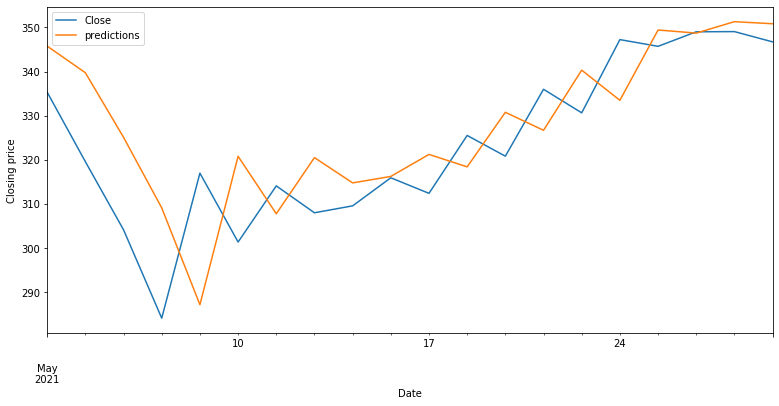

In [96]:
# Performance report
rmse = sqrt(mean_squared_error(raw_values[-20:], Multi_predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
Multi_temp_df = pd.DataFrame(raw_values[-20:])
Multi_temp_df['predictions'] = Multi_predictions
Multi_temp_df.plot(legend=True, figsize=(13,6))
plt.ylabel('Closing price')
plt.show()

In [226]:
# Creating Train Predictions
Multi_train_predictions = list()
for i in range(len(Multi_train_scaled[-30:])):
    # make one-step forecast
    X, y = Multi_train_scaled[-30:][i, 0:-1], Multi_train_scaled[-30:][i, -1]
    yhat = forecast_lstm(Multi_model, 1, X)
    
    # invert scaling
    yhat = invert_scale(Multi_scaler, X, yhat)
    
    # store forecast
    Multi_train_predictions.append(yhat)

Multi_train_predictions

[345.2997432331155,
 352.75125188105443,
 341.1720118862867,
 320.3017496473754,
 319.70055545521933,
 309.8253667594234,
 306.96616510713824,
 318.51658634014535,
 329.0960297451376,
 336.1331989482723,
 336.1331989482723,
 333.18130265966414,
 360.0292496682976,
 360.5966707186097,
 370.544918034143,
 370.65786714426696,
 368.3228415937504,
 380.4132499216824,
 370.00304195576706,
 379.7094859448417,
 372.9872593562355,
 361.109156634537,
 356.0773282296388,
 357.5916677778185,
 352.23543167405336,
 357.90131317185075,
 367.3602532723083,
 360.94331598778314,
 358.4552760553691,
 357.4240389830291]

In [227]:
Multi_Training_predictions_df = pd.DataFrame(raw_values[-50:-20])
Multi_Training_predictions_df['Train_predictions'] = Multi_train_predictions

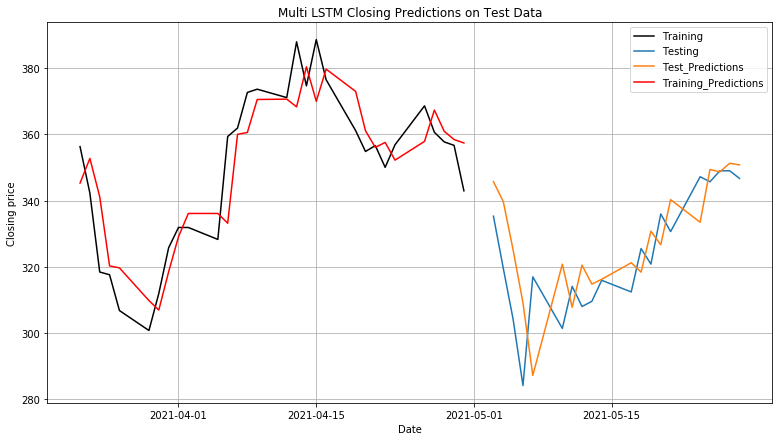

In [230]:
plt.figure(figsize=(13,7))
plt.plot(raw_values[-50:-20], label='Training', color='black')
Multi_temp_df = pd.DataFrame(raw_values[-20:])
Multi_temp_df['predictions'] = Multi_predictions
plt.plot(Multi_temp_df['Close'], label='Testing')
plt.plot(Multi_temp_df['predictions'], label='Test_Predictions')
plt.plot(Multi_Training_predictions_df['Train_predictions'], label='Training_Predictions', color='red')
plt.plot()
plt.title('Multi LSTM Closing Predictions on Test Data')
plt.legend()
plt.ylabel('Closing price')
plt.xlabel('Date')
plt.grid()
plt.show()

In [224]:
# # Saving Model
# filename = 'Multi_LSTM_model.sav'
# pickle.dump(Multi_model, open(filename, 'wb'))